<a href="https://colab.research.google.com/github/Santosh155/timeseries/blob/master/pharmacy_stock_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Importing the datasets

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Santosh155/timeseries/master/pharmacy_data.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [ ]:
df

,Stock,item
Month,,
2011-01-01,2815,Item-1
2011-02-01,2672,Item-1
2011-03-01,2755,Item-1
2011-04-01,2721,Item-1
2011-05-01,2946,Item-1
...,...,...
2013-08-01,1821,Item-2
2013-09-01,5222,Item-2
2013-10-01,6872,Item-2


Grouping items into their respected group

```
# This is formatted as code
```



In [ ]:
groups = df.groupby("item")

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Testing for data stationary or not

In [ ]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

forecasting the datasets and converting to integer from float

In [ ]:
def forecast(model, start=pd.to_datetime("2013-01-01"), end=pd.to_datetime("2013-12-01")):
  gdf["forecast"] = model.predict(start=start,end=end,dynamic=True)
  forecasting_integer = gdf['forecast'].dropna()
  forecasting_integer = forecasting_integer.astype(np.int64)
  return forecasting_integer

Evaluating the model using MAPE(Mean Absolute Percentage Error)

In [ ]:
# Evaluating models
def mape_score(expected, predicted): 
    expected, predicted = np.array(expected), np.array(predicted)
    return np.mean(np.abs((expected - predicted) / expected)) * 100

In [ ]:
for group_id, gdf in groups:
    print("\n\nThis is for {}\n".format(group_id))
    gdf['Stock First Difference'] = gdf['Stock'] - gdf['Stock'].shift(1)
    test_result = adfuller_test(gdf['Stock First Difference'].dropna())



This is for Item-1

ADF Test Statistic : -18.1942957385571
p-value : 2.414851333509681e-30
#Lags Used : 10
Number of Observations Used : 24
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


This is for Item-2

ADF Test Statistic : -9.939092259588115
p-value : 2.6941257541146882e-17
#Lags Used : 10
Number of Observations Used : 24
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Splitting datasets into train and test

In [ ]:
def train_test(df):
    x = df.values
    size = int(len(x) * 0.71)
    train, test = df.iloc[:size, 0:1], df.iloc[size:, 0:1]
    return train, test

In [ ]:
import itertools
def grid_search(stock, seasonal=[12]):
    order = list()
    p_params = range(0, 2)
    d_params = range(0, 2)
    q_params = range(0, 2)
    P_params = range(0, 2)
    D_params = range(0, 2)
    Q_params = range(0, 2)
    m_params = seasonal
    pdq = list(itertools.product(p_params, d_params, q_params))
    PDQm = list(itertools.product(P_params, D_params, Q_params, m_params))
    pP=list(itertools.product(pdq, PDQm))
    # print(len(pdq))
    # print(pdq)
    # print(len(PDQm))
    # print(PDQm)
    # print(len(pP))
    # print(pP)
    _selected_model = None
    _selected_pdq = None
    _selected_PDQm =None
    _score = 0
    for _pdq, _PDQm in pP:
        try:
            p,d,q = _pdq
            P,D,Q,m = _PDQm
            model=sm.tsa.statespace.SARIMAX(stock, order=(p,d,q), seasonal_order=(P, D, Q, m))
            model=model.fit()
#             _selected_model.append(model)
            score = model.aic
            if _selected_model is None:
                _selected_model = model
                _selected_pdq = _pdq
                _selected_PDQm =_PDQm
                _score = score
            else:
                if score < _score:
                    _selected_model = model
                    _selected_pdq = _pdq
                    _selected_PDQm =_PDQm
                    _score = score
        except:
            continue
    return _selected_model, _selected_pdq, _selected_PDQm

Training the data

In [ ]:
import pickle
models = {}
for group_id, gdf in groups:
    print("\n\nThis is for {}\n".format(group_id))
    train, test = train_test(gdf)
    model, pdq, pdqm = grid_search(train)
    print(model)
    print(pdq)
    print(pdqm)
    models[group_id] = model
    pred = forecast(model)
    expected, predicted = np.array(gdf.iloc[25:36, 0:1]), np.array(gdf.iloc[25:36, 2:3])
    mape = mape_score(expected, predicted)
    print("\n\nEvaluating for {}".format(group_id))
    print("MAPE is %.3f"%mape)

with open('final_year_pharmacy_forecasting_project', 'wb') as f:
    pickle.dump(models, f)



This is for Item-1

(0, 1, 1)
(0, 1, 0, 12)


Evaluating for Item-1
MAPE is 10.517


This is for Item-2

(0, 1, 1)
(0, 1, 0, 12)


Evaluating for Item-2
MAPE is 19.066


In [ ]:
models

{'Item-1': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f516dddc390>,
 'Item-2': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f516dddc7b8>}

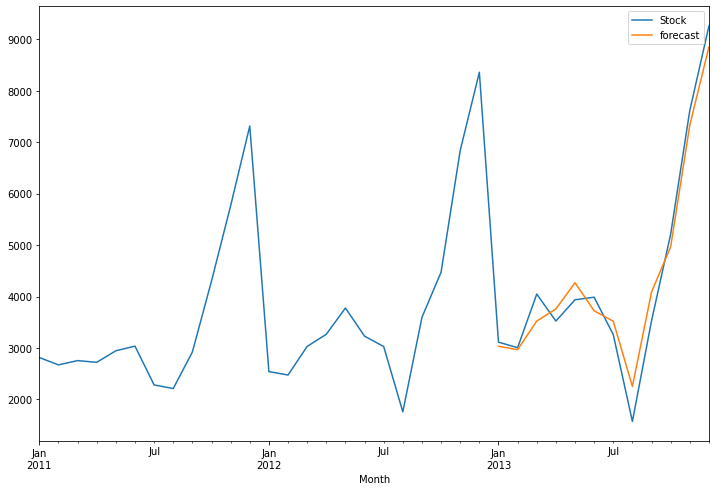

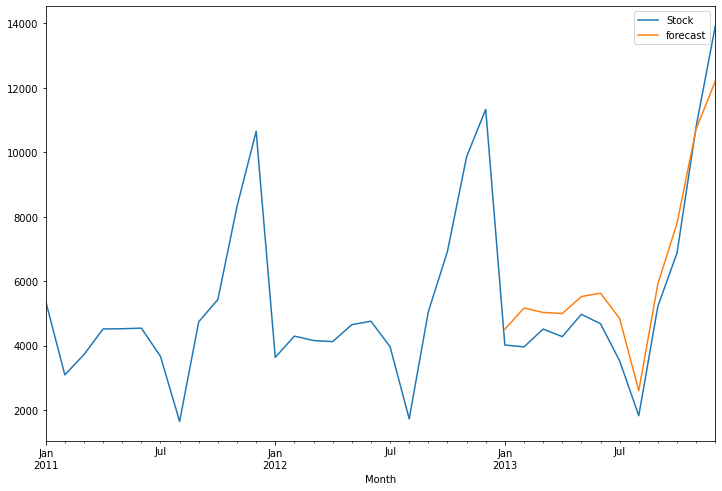

In [ ]:
# Prediction 
for group_id, gdf in groups:
    model = models.get(group_id)
    stock = df['Stock']
    forecast(model)
    gdf[['Stock', 'forecast']].plot(figsize=(12,8))

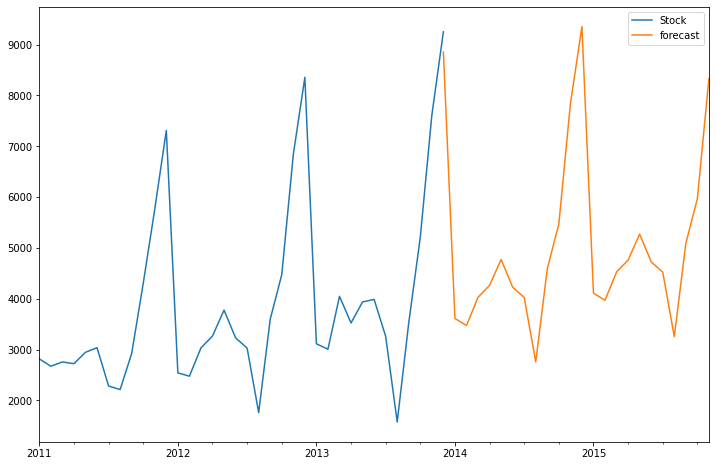

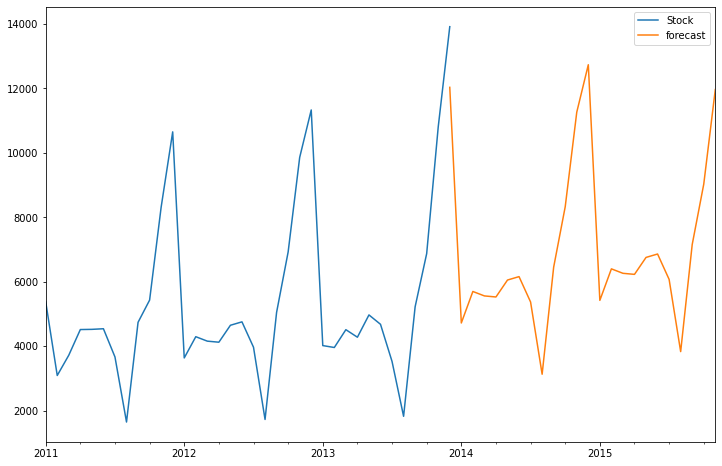

In [ ]:
# Future Prediction 
from pandas.tseries.offsets import DateOffset
future_prediction = dict()
for group_id, gdf in groups:
    model = models.get(group_id)
    future_dates=[gdf.index[-1]+ DateOffset(months=x)for x in range(0,24)]
    future_datest_df=pd.DataFrame(index=future_dates[1:],columns=gdf.columns)
    gdf=pd.concat([gdf,future_datest_df])
    forecast(model, start=pd.to_datetime('2013-12-01'), end=pd.to_datetime('2015-11-01'))
    gdf[['Stock', 'forecast']].plot(figsize=(12, 8)) 
    actual, predicted = gdf.iloc[0:35, 2:3], gdf.iloc[35:, 2:3]
    predicted = predicted.applymap(np.int64)
    future_prediction[group_id] = predicted

In [ ]:
future_prediction

{'Item-1':             forecast
 2013-12-01      8855
 2014-01-01      3611
 2014-02-01      3471
 2014-03-01      4027
 2014-04-01      4262
 2014-05-01      4772
 2014-06-01      4226
 2014-07-01      4024
 2014-08-01      2755
 2014-09-01      4591
 2014-10-01      5470
 2014-11-01      7834
 2014-12-01      9353
 2015-01-01      4109
 2015-02-01      3970
 2015-03-01      4526
 2015-04-01      4761
 2015-05-01      5271
 2015-06-01      4725
 2015-07-01      4523
 2015-08-01      3254
 2015-09-01      5090
 2015-10-01      5969
 2015-11-01      8333, 'Item-2':             forecast
 2013-12-01     12033
 2014-01-01      4718
 2014-02-01      5696
 2014-03-01      5558
 2014-04-01      5525
 2014-05-01      6051
 2014-06-01      6157
 2014-07-01      5369
 2014-08-01      3127
 2014-09-01      6452
 2014-10-01      8326
 2014-11-01     11262
 2014-12-01     12735
 2015-01-01      5420
 2015-02-01      6398
 2015-03-01      6260
 2015-04-01      6227
 2015-05-01      6753
 2015-06-01 

In [ ]:
  with open('final_year_pharmacy_forecasting_project', 'rb') as f:
    test = pickle.load(f)

In [27]:
int_data = test['Item-1'].predict(start='2018-10-01', end='2022-12-01')
int_data.astype(np.int64)

2018-10-01     7464
2018-11-01     9828
2018-12-01    11347
2019-01-01     6103
2019-02-01     5963
2019-03-01     6519
2019-04-01     6754
2019-05-01     7264
2019-06-01     6718
2019-07-01     6516
2019-08-01     5247
2019-09-01     7083
2019-10-01     7962
2019-11-01    10326
2019-12-01    11845
2020-01-01     6601
2020-02-01     6461
2020-03-01     7017
2020-04-01     7252
2020-05-01     7762
2020-06-01     7216
2020-07-01     7014
2020-08-01     5745
2020-09-01     7581
2020-10-01     8460
2020-11-01    10824
2020-12-01    12343
2021-01-01     7099
2021-02-01     6960
2021-03-01     7516
2021-04-01     7751
2021-05-01     8261
2021-06-01     7715
2021-07-01     7513
2021-08-01     6244
2021-09-01     8080
2021-10-01     8959
2021-11-01    11323
2021-12-01    12842
2022-01-01     7598
2022-02-01     7458
2022-03-01     8014
2022-04-01     8249
2022-05-01     8759
2022-06-01     8213
2022-07-01     8011
2022-08-01     6742
2022-09-01     8578
2022-10-01     9457
2022-11-01    11821
